In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch

In [2]:
from rllib_emecom.utils.experiment_utils import initialise_ray
initialise_ray(include_dashboard=False)

pygame 2.3.0 (SDL 2.24.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


2023-11-07 07:33:21,715	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
2023-11-07 07:33:24,556	INFO worker.py:1649 -- Started a local Ray instance.


In [3]:
from IPython.display import clear_output
from ray.rllib.algorithms.algorithm import Algorithm

In [4]:
runs_dir = 'ray_results/goal_comms_gridworld/goal_comms_gridworld/'
run = 'PPOMACRL_goal_comms_gridworld_e7527_00000_0_2023-11-06_13-24-44'
ckpt = 'checkpoint_000089'
algo = Algorithm.from_checkpoint(f'{runs_dir}{run}/{ckpt}')
clear_output()
print('Loaded checkpoint.')

Loaded checkpoint.


In [5]:
eval_results = algo.evaluate()
eval_results.keys()

(RolloutWorker pid=2020153) IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1812, 608) to (1824, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
(RolloutWorker pid=2020153) [rawvideo @ 0x5a2d580] Stream #0: not enough frames to estimate rate; consider increasing probesize


(RolloutWorker pid=2020153) Saved evaluation video to /home/dylancope/ray_results/PPOMACRL_goal_comms_gridworld_2023-11-07_07-38-36_6gougb9//videos//video_2023-11-07_07-40-10.mp4


dict_keys(['evaluation'])

In [6]:
print('Episode Reward Mean:', eval_results['evaluation']['episode_reward_mean'])

Episode Reward Mean: -9.8


In [7]:
from rllib_emecom.utils.video_utils import embed_mp4
media = eval_results['evaluation']['sampler_results']['episode_media']
for k in media:
    if k.startswith('env'):
        video, *_ = media[k]
        break
embed_mp4(video._path)

In [8]:
# from typing import Optional, Dict, Union

# from ray.rllib.core.models.base import SampleBatch
# from ray.rllib.algorithms.callbacks import DefaultCallbacks, make_multi_callbacks
# from ray.rllib.evaluation.episode import Episode
# from ray.rllib.evaluation.episode_v2 import EpisodeV2
# from ray.rllib.utils.typing import PolicyID
# from ray.rllib import Policy, BaseEnv

# from rllib_emecom.utils.video_callback import get_sub_env
# from rllib_emecom.macrl.ppo.macrl_ppo_module import PPOTorchMACRLModule
# from rllib_emecom.env.goal_comms_gridworld import parallel_env as GoalCommsGridworldEnv


# class CollectCommsDataCallback(DefaultCallbacks):

#     def __init__(self):
#         super().__init__()
#         self.data = []

#     def get_env_state(self, goal_comms_env: GoalCommsGridworldEnv) -> dict:
#         agent_ids = goal_comms_env.agents

#         def get_known_goal_agent(agent):
#             # agent knows the goal of agent_goal_map[agent]
#             other_agent = goal_comms_env.agent_goal_map[agent]
#             return agent_ids[other_agent.index]

#         return {
#             # key knows the goal of the value
#             # so key is the sender and value is the receiver
#             'goal_knowledge_map' : {
#                 agent: get_known_goal_agent(agent)
#                 for agent in agent_ids
#             },
#             'agent_positions': {
#                 agent: goal_comms_env.agents_map[agent].pose
#                 for agent in agent_ids
#             },
#             'goal_positions': {
#                 agent: goal_comms_env.agents_map[agent].goal
#                 for agent in agent_ids
#             },
#         }

#     def on_episode_step(
#         self,
#         *,
#         worker,
#         base_env: BaseEnv,
#         policies: Optional[Dict[PolicyID, Policy]] = None,
#         episode: EpisodeV2,
#         env_index: Optional[int] = None,
#         **kwargs,
#     ) -> None:
#         assert isinstance(policies, dict), f"Expected dict, got: {policies}"
#         macrl_module = policies['default_policy'].model
#         assert isinstance(macrl_module, PPOTorchMACRLModule)
#         env = get_sub_env(base_env, env_index)
#         goal_comms_env = env.env.unwrapped.par_env
#         assert isinstance(goal_comms_env, GoalCommsGridworldEnv)

#         if macrl_module.last_actor_outputs is None:
#             return

#         last_action_logits = {   
#             agent_id: action_batch[SampleBatch.ACTION_DIST_INPUTS][env_index].detach().cpu().numpy()
#             for agent_id, action_batch in macrl_module.last_actor_outputs.items()
#         }

#         self.data.append({
#             'comms': macrl_module.get_last_msgs(env_index),
#             'total_env_steps': episode.total_env_steps,
#             'total_reward': episode.total_reward,
#             'episode_id': episode.episode_id,
#             'env_index': env_index,
#             'last_obs': macrl_module.last_inputs[SampleBatch.OBS][env_index] if macrl_module.last_inputs is not None else None,
#             'last_action_logits': last_action_logits,
#             'env_state': self.get_env_state(goal_comms_env),
#         })

In [31]:
from rllib_emecom.utils.video_callback import VideoEvaluationsCallback
from ray.rllib.evaluation.worker_set import WorkerSet
from rllib_emecom.utils.comms_data_collection import CollectCommsDataCallback

eval_config = algo.evaluation_config.copy(copy_frozen=False)
eval_config.callbacks_class = CollectCommsDataCallback

eval_worker_set = WorkerSet(
    env_creator=algo.env_creator,
    validate_env=None,
    default_policy_class=algo.get_default_policy_class(algo.config),
    config=eval_config,
    num_workers=0,
    logdir=algo.logdir,
)

worker = eval_worker_set.local_worker()

2023-11-07 07:48:04,176	WARNING algorithm_config.py:2574 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.


Building MACRL module...
Comms spec: {'message_dim': 3, 'comm_channels': {'agent_0': ['agent_1', 'agent_2'], 'agent_1': ['agent_0', 'agent_2'], 'agent_2': ['agent_0', 'agent_1']}, 'channel_fn': 'gumbel_softmax', 'channel_fn_config': {'temperature': 3.0, 'temperature_annealing': False, 'annealing_start_iter': 0, 'n_anneal_iterations': 500, 'final_temperature': 0.5, 'channel_noise': 0.25, 'channel_activation': 'tanh'}, 'n_agents': 3}
Communication channel function: <rllib_emecom.macrl.comms.gumbel_softmax.GumbelSoftmaxCommunicationChannel object at 0x7f68c87b75e0>


In [32]:
policy = worker.get_policy('default_policy')
module = policy.model
module.comm_channel_fn.set_force_eval(True)
module.comm_channel_fn, module.comm_channel_fn.temperature

(<rllib_emecom.macrl.comms.gumbel_softmax.GumbelSoftmaxCommunicationChannel at 0x7f68c87b75e0>,
 3.0)

In [33]:
algo.evaluation_workers = eval_worker_set
collect_comms_data_cb = worker.callbacks
collect_comms_data_cb.data.clear()

In [34]:
import tqdm

n_evals = 150

mean_reward = 0
mean_episode_length = 0

progbar = tqdm.tqdm(range(n_evals))

for i in range(n_evals):
    eval_results = algo.evaluate()

    mean_reward += eval_results['evaluation']['sampler_results']['episode_reward_mean']
    mean_episode_length += eval_results['evaluation']['sampler_results']['episode_len_mean']

    progbar.set_postfix_str(f'Mean reward: {mean_reward / (i + 1):.2f}, '
                            f'Mean episode length: {mean_episode_length / (i + 1):.2f}')
    progbar.update()

progbar.close()

mean_reward /= n_evals
mean_episode_length /= n_evals

100%|██████████| 150/150 [02:16<00:00,  1.10it/s, Mean reward: -8.87, Mean episode length: 7.00]

Mean reward: -8.87, Mean episode length: 7.00


In [35]:
len(collect_comms_data_cb.data)

26248

In [36]:
collect_comms_data_cb.data[0]

{'comms': {'agent_0': {'agent_1': array([0., 0., 1.], dtype=float32),
   'agent_2': array([0., 0., 1.], dtype=float32)},
  'agent_1': {'agent_0': array([0., 1., 0.], dtype=float32),
   'agent_2': array([1., 0., 0.], dtype=float32)},
  'agent_2': {'agent_0': array([1., 0., 0.], dtype=float32),
   'agent_1': array([1., 0., 0.], dtype=float32)}},
 'total_env_steps': 1,
 'total_reward': -1.0,
 'episode_id': 394059495633261848,
 'env_index': 0,
 'last_obs': tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0

In [37]:
# df = pd.DataFrame([
#     {
#         'receiver': recv_agent,
#         'sender': send_agent,
#         'goal_x': item['env_state']['goal_positions'][recv_agent][0],
#         'goal_y': item['env_state']['goal_positions'][recv_agent][1],
#         'pos_x': item['env_state']['agent_positions'][recv_agent][0],
#         'pos_y': item['env_state']['agent_positions'][recv_agent][1],
#         'sender_pos_x': item['env_state']['agent_positions'][send_agent][0],
#         'sender_pos_y': item['env_state']['agent_positions'][send_agent][1],
#         'receiver_action': np.argmax(item['last_action_logits'][recv_agent]),
#         **{
#             f'msg_{i}': v
#             for i, v in enumerate(item['comms'][recv_agent][send_agent])
#         },
#     }
#     for item in collect_comms_data_cb.data
#     for recv_agent in item['comms']
#     for send_agent in item['comms'][recv_agent]
#     if item['env_state']['goal_knowledge_map'][send_agent] == recv_agent
# ])
# msg_cols = [col for col in df.columns if col.startswith('msg_')]
# world_w, world_h = eval_config.env_config['world_shape']
# df['goal_idx'] = df['goal_x'] + df['goal_y'] * world_w
# df['pos_idx'] = df['pos_x'] + df['pos_y'] * world_w
# df.head()

In [40]:
df = collect_comms_data_cb.get_dataframe()
df

,receiver,sender,goal_x,goal_y,pos_x,pos_y,sender_pos_x,sender_pos_y,world_w,world_h,receiver_action,msg,goal_vec,msg_0,msg_1,msg_2,goal_grid_idx,pos_grid_idx
0,agent_0,agent_2,4,4,1,1,2,4,5,5,4,2,"[1, 0, 0]",0.0,0.0,1.0,24,6
1,agent_1,agent_0,0,3,0,3,1,1,5,5,1,1,"[0, 0, 1]",0.0,1.0,0.0,15,15
2,agent_2,agent_1,1,2,2,4,0,3,5,5,3,0,"[0, 1, 0]",1.0,0.0,0.0,11,22
3,agent_0,agent_2,4,4,2,1,2,3,5,5,4,2,"[1, 0, 0]",0.0,0.0,1.0,24,7
4,agent_1,agent_0,0,3,0,4,2,1,5,5,1,1,"[0, 0, 1]",0.0,1.0,0.0,15,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78739,agent_1,agent_0,0,2,0,1,4,4,5,5,2,1,"[1, 0, 0]",0.0,1.0,0.0,10,5
78740,agent_2,agent_1,2,2,2,1,0,1,5,5,1,1,"[0, 0, 1]",0.0,1.0,0.0,12,7
78741,agent_0,agent_2,4,4,4,3,2,2,5,5,2,2,"[0, 1, 0]",0.0,0.0,1.0,24,19
78742,agent_1,agent_0,0,2,0,0,4,3,5,5,2,1,"[1, 0, 0]",0.0,1.0,0.0,10,0


In [49]:
world_w, *_ = df.world_w.unique()
world_h, *_ = df.world_h.unique()
msg_cols = [col for col in df.columns if col.startswith('msg_')]
msg_label_col = 'msg'
goal_idx_col = 'goal_grid_idx'
recv_action_col = 'receiver_action'

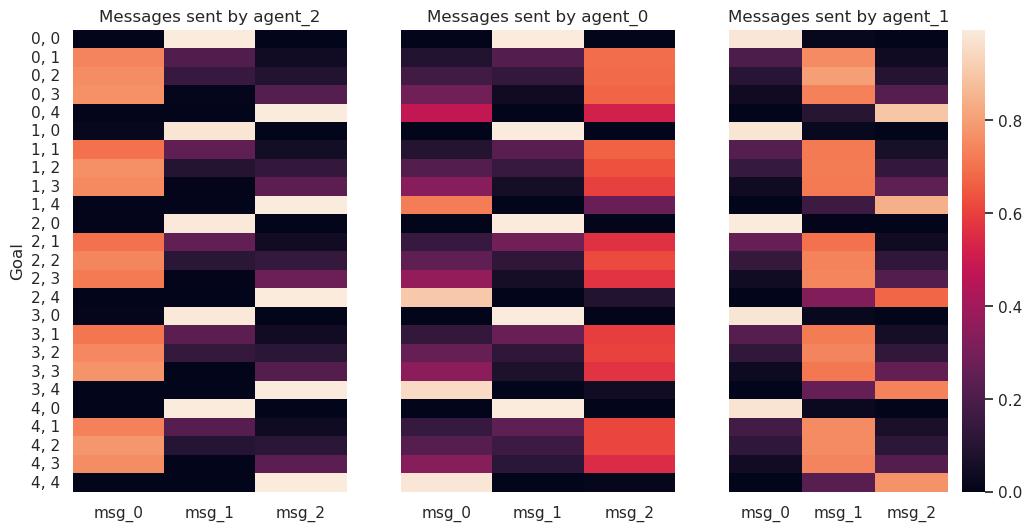

In [48]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    goal_mean_msgs = df[df.sender == agent].groupby(goal_idx_col)[msg_cols].mean()
    goal_mean_msgs = goal_mean_msgs.reset_index().set_index(goal_idx_col)
    sns.heatmap(goal_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])

plt.show()

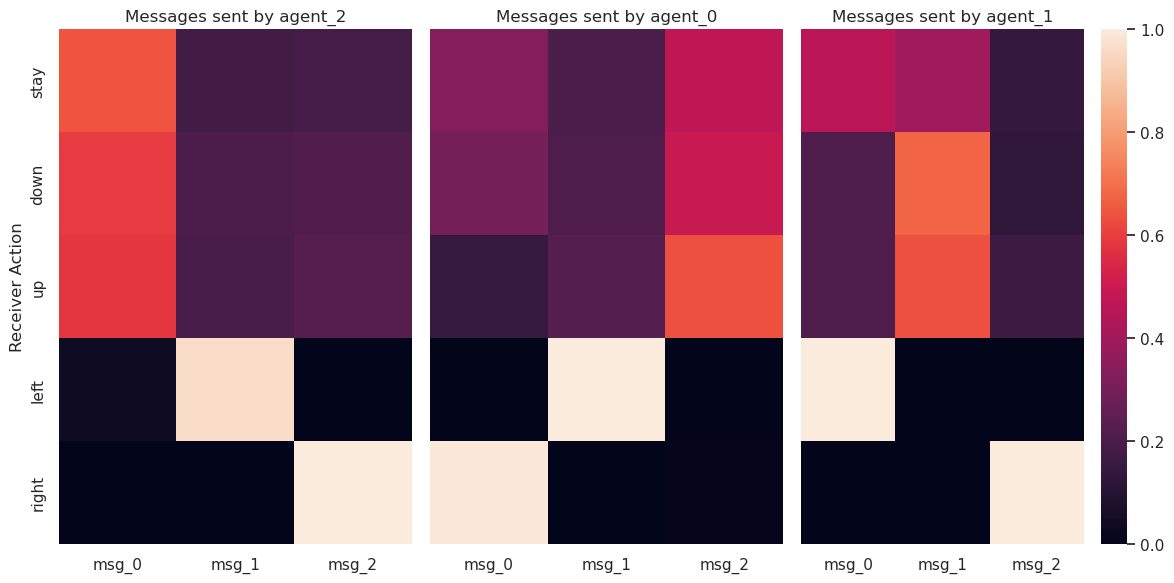

In [50]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    action_mean_msgs = df[df.sender == agent].groupby(recv_action_col)[msg_cols].mean()
    action_mean_msgs = action_mean_msgs.reset_index().set_index(recv_action_col)
    sns.heatmap(action_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1, vmin=0, vmax=1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Receiver Action')
        axs[i].set_yticklabels(["stay", "down", "up", "left", "right"])

plt.tight_layout()
plt.show()

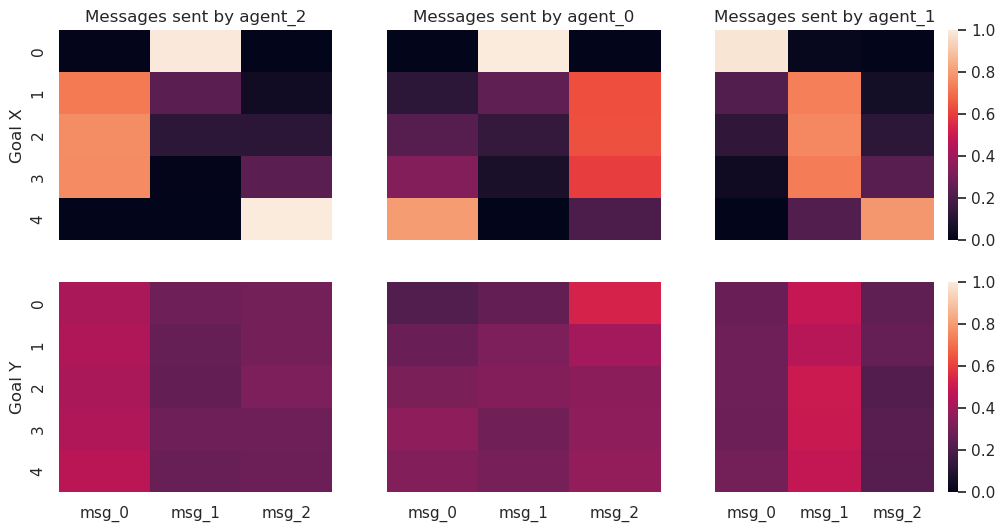

In [51]:
agents = df['sender'].unique()
_, axs_grid = plt.subplots(2, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df.sender == agent]
    
    goal_x_mean_msgs = agent_df.groupby('goal_x')[msg_cols].mean()
    goal_x_mean_msgs = goal_x_mean_msgs.reset_index().set_index('goal_x')
    sns.heatmap(goal_x_mean_msgs, ax=axs_grid[0][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    goal_y_mean_msgs = agent_df.groupby('goal_y')[msg_cols].mean()
    goal_y_mean_msgs = goal_y_mean_msgs.reset_index().set_index('goal_y')
    sns.heatmap(goal_y_mean_msgs, ax=axs_grid[1][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    axs_grid[0][i].set_title(f'Messages sent by {agent}')
    axs_grid[0][i].set_xticks([])
    if i > 0:
        axs_grid[0][i].set_ylabel('')
        axs_grid[0][i].set_yticks([])
        axs_grid[1][i].set_ylabel('')
        axs_grid[1][i].set_yticks([])
    else:
        axs_grid[0][i].set_ylabel('Goal X')
        axs_grid[1][i].set_ylabel('Goal Y')

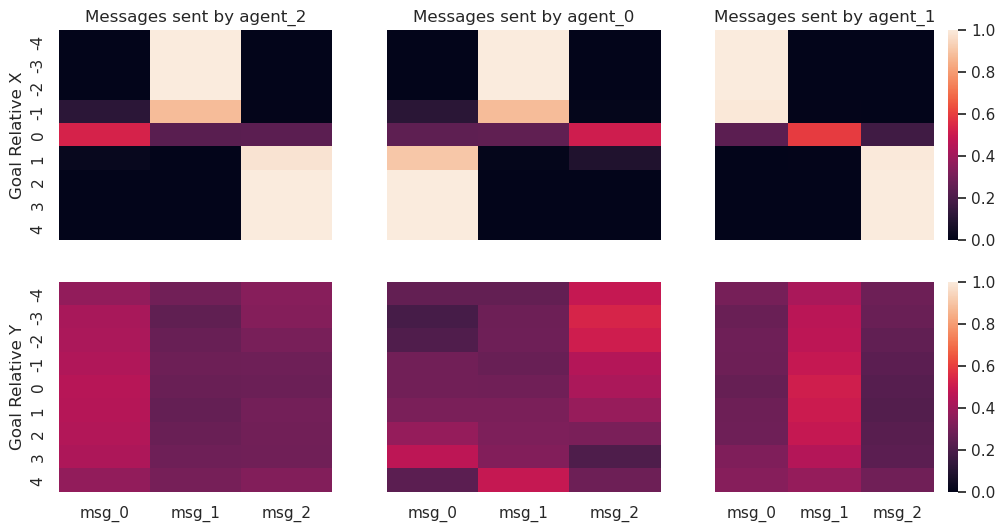

In [52]:
df['goal_rel_x'] = df['goal_x'] - df['pos_x']
df['goal_rel_y'] = df['goal_y'] - df['pos_y']
agents = df['sender'].unique()
_, axs_grid = plt.subplots(2, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df.sender == agent]
    
    goal_x_mean_msgs = agent_df.groupby('goal_rel_x')[msg_cols].mean()
    goal_x_mean_msgs = goal_x_mean_msgs.reset_index().set_index('goal_rel_x')
    sns.heatmap(goal_x_mean_msgs, ax=axs_grid[0][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    goal_y_mean_msgs = agent_df.groupby('goal_rel_y')[msg_cols].mean()
    goal_y_mean_msgs = goal_y_mean_msgs.reset_index().set_index('goal_rel_y')
    sns.heatmap(goal_y_mean_msgs, ax=axs_grid[1][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    axs_grid[0][i].set_title(f'Messages sent by {agent}')
    axs_grid[0][i].set_xticks([])
    if i > 0:
        axs_grid[0][i].set_ylabel('')
        axs_grid[0][i].set_yticks([])
        axs_grid[1][i].set_ylabel('')
        axs_grid[1][i].set_yticks([])
    else:
        axs_grid[0][i].set_ylabel('Goal Relative X')
        axs_grid[1][i].set_ylabel('Goal Relative Y')

In [53]:
import torch
from torch import nn

class MLP(nn.Module):

    def __init__(self,
                 input_size,
                 output_size,
                 hidden_sizes,
                 activation=nn.ReLU):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.activation = activation

        self.layers = nn.ModuleList()
        last_size = input_size
        for size in hidden_sizes:
            self.layers.append(nn.Linear(last_size, size))
            self.layers.append(activation())
            last_size = size
        self.layers.append(nn.Linear(last_size, output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [82]:
sender = 'agent_0'
msg_cols = [col for col in df.columns if col.startswith('msg') and col != 'msg_idx']
broca_data = df[df.sender == sender][msg_cols + ['receiver_action']]
broca_data = [
    (
        torch.tensor(row[msg_cols], dtype=torch.float32),
        torch.tensor(row['receiver_action'], dtype=torch.long),
    )
    for _, row in broca_data.iterrows()
]

In [142]:
import tqdm
from torch.utils.data import DataLoader
from torcheval import metrics

from typing import Dict, Optional


class Trainer:

    def __init__(self,
                 model,
                 training_data: DataLoader,
                 optimiser,
                 loss_fn,
                 n_epochs=10,
                 eval_data=None,
                 eval_frequency=5,
                 leave_bar_freq=5,
                 metrics: Optional[Dict[str, metrics.Metric]]=None,
                 device='cuda'):
        self.model = model
        self.loss_fn = loss_fn
        self.training_data = training_data
        self.optimiser = optimiser
        self.n_epochs = n_epochs
        self.leave_bar_freq = leave_bar_freq
        self.device = device
        self.eval_data = eval_data
        self.eval_frequency = eval_frequency
        self.metrics = metrics or {}
        self.history = []

    @property
    def history_df(self):
        return pd.DataFrame(self.history)

    def train_one_epoch(self, epoch_index: int) -> dict:
        last_loss = 0.

        progbar = tqdm.tqdm(
            desc=f'Epoch {epoch_index}',
            total=len(self.training_data),
            leave=False,
        )

        self.model.to(self.device)

        for metric in self.metrics.values():
            metric.reset()
            metric.to(self.device)

        for i, (inputs, labels) in enumerate(iter(self.training_data)):
            self.optimiser.zero_grad()

            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            self.optimiser.step()

            for metric in self.metrics.values():
                metric.update(outputs, labels)

            last_loss = loss.item()
            progbar.set_postfix_str(f'Step {i}, Loss: {last_loss:.3f}')
            progbar.update()

        train_logs = {'Loss': last_loss}

        train_logs.update(self._get_metrics(self.metrics))

        if epoch_index % self.leave_bar_freq == 0:
            progbar.leave = True

        progbar.set_postfix_str(', '.join([
            f'{k}: {metric_val:.3f}'
            for k, metric_val in train_logs.items()
        ]))
        progbar.close()

        return train_logs

    @staticmethod
    def _get_metrics(metrics: dict, name_prefix: str = ''):

        def is_scalar(metric):
            return metric.shape == torch.Size([])

        return {
            f'{name_prefix}{metric_name}': val.item()
                                           if is_scalar(val := metric.compute()) else
                                           val.cpu().numpy()
            for metric_name, metric in metrics.items()
        }

    def train(self):
        self.model.train(True)
        self.history = []

        try:
            for epoch in range(self.n_epochs):
                epoch_logs = {'Epoch': epoch}

                train_logs = self.train_one_epoch(epoch)

                epoch_logs.update(train_logs)

                if self.eval_data is not None and epoch % self.eval_frequency == 0:
                    eval_logs = self.evaluate()
                    epoch_logs.update(eval_logs)

                self.history.append(epoch_logs)

        except KeyboardInterrupt:
            print('Interrupted training.')

    def evaluate(self,
                 eval_data=None,
                 additional_metrics: Dict[str, metrics.Metric]=None) -> dict:
        self.model.eval()

        eval_data = eval_data or self.eval_data

        metrics = {
            **self.metrics,
            **(additional_metrics or {}),
        }

        assert eval_data is not None, 'No evaluation data provided.'

        progbar = tqdm.tqdm(
            desc=f'Evaluation',
            total=len(eval_data),
            leave=False,
        )

        for metric in metrics.values():
            metric.reset()
            metric.to(self.device)

        with torch.no_grad():
            total_loss = 0.
            self.model.to(self.device)
            for inputs, labels in iter(eval_data):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                total_loss += loss.item()

                for metric in metrics.values():
                    metric.update(outputs, labels)

                progbar.set_postfix_str(f'Loss: {loss.item():.3f}')
                progbar.update()

        progbar.leave = True
        progbar.close()

        eval_logs = {'Eval/Loss': total_loss / len(eval_data)}
        eval_logs.update(self._get_metrics(metrics, 'Eval/'))

        return eval_logs

In [126]:
batch_size = 1024
n_epochs = 100
training_split = 0.8
split_idx = int(len(broca_data) * training_split)
training_data = broca_data[:split_idx]
training_data = torch.utils.data.DataLoader(training_data, batch_size=batch_size)

eval_data = broca_data[split_idx:]
eval_data = torch.utils.data.DataLoader(eval_data, batch_size=batch_size)

In [143]:
n_msgs = len(msg_cols)
n_actions = 5
broca_fn = MLP(
    n_msgs, n_actions,
    hidden_sizes=[64, 64],
)
broca_fn.to('cuda')
msg_sent, action_taken = next(iter(training_data))
msg_sent = msg_sent.to('cuda')
action_pred = broca_fn(msg_sent)
action_pred.shape

torch.Size([1024, 5])

In [144]:
optimiser = torch.optim.SGD(broca_fn.parameters(), lr=0.001, momentum=0.9)

from torcheval import metrics

training_metrics = {
    'Accuracy': metrics.MulticlassAccuracy(),
}

trainer = Trainer(broca_fn,
                  training_data,
                  optimiser=optimiser,
                  loss_fn=nn.CrossEntropyLoss(),
                  eval_data=eval_data,
                  metrics=training_metrics,
                  n_epochs=100,)

In [145]:
trainer.train()

Evaluation: 100%|██████████| 6/6 [00:00<00:00, 372.79it/s, Loss: 0.969]


In [166]:
eval_metrics = trainer.evaluate(additional_metrics={
    'Confusion': metrics.MulticlassConfusionMatrix(num_classes=n_actions, normalize='true')
})
eval_metrics

Evaluation: 100%|██████████| 6/6 [00:00<00:00, 192.79it/s, Loss: 0.969]


{'Eval/Loss': 0.9633625050385793,
 'Eval/Accuracy': 0.519428551197052,
 'Eval/Confusion': array([[0.        , 0.        , 0.5       , 0.16216215, 0.33783785],
        [0.        , 0.        , 0.5108153 , 0.18524681, 0.30393788],
        [0.        , 0.        , 0.6606383 , 0.20797873, 0.13138297],
        [0.        , 0.        , 0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.01078167, 0.        , 0.98921835]],
       dtype=float32)}

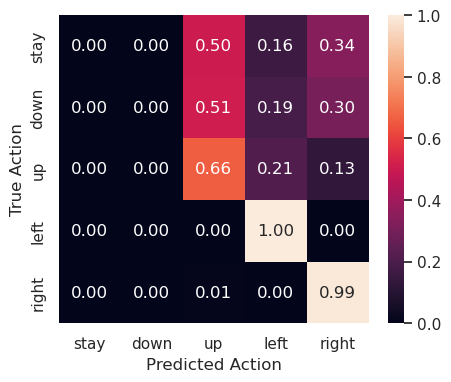

In [167]:
_, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.heatmap(eval_metrics['Eval/Confusion'], annot=True, fmt='.2f', ax=ax)
ax.set_xticklabels(["stay", "down", "up", "left", "right"])
ax.set_yticklabels(["stay", "down", "up", "left", "right"])
ax.set_xlabel('Predicted Action')
ax.set_ylabel('True Action')
plt.show()

In [168]:
history_df = trainer.history_df

In [173]:
history_df

,Epoch,Loss,Accuracy,Eval/Loss,Eval/Accuracy
0,0,1.550978,0.354129,1.543301,0.358095
1,1,1.477609,0.354129,NaN,NaN
2,2,1.412883,0.354129,NaN,NaN
3,3,1.359275,0.354129,NaN,NaN
4,4,1.314117,0.354129,NaN,NaN
...,...,...,...,...,...
95,95,0.962122,0.497666,0.964024,0.519429
96,96,0.962019,0.497666,NaN,NaN
97,97,0.961898,0.497666,NaN,NaN
98,98,0.961799,0.497666,NaN,NaN


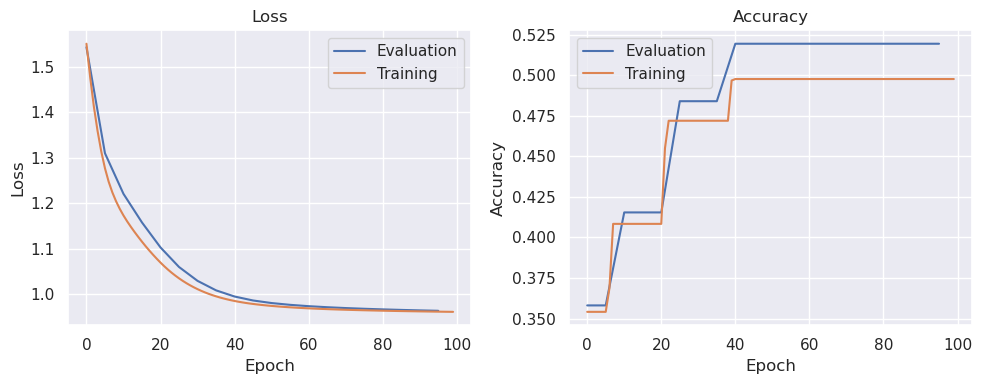

In [178]:
_, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].set_title('Loss')
sns.lineplot(history_df, ax=axs[0], x='Epoch', y='Eval/Loss', label='Evaluation')
sns.lineplot(history_df, ax=axs[0], x='Epoch', y='Loss', label='Training')
axs[0].legend()
axs[0].set_ylabel('Loss')

axs[1].set_title('Accuracy')
sns.lineplot(history_df, ax=axs[1], x='Epoch', y='Eval/Accuracy', label='Evaluation')
sns.lineplot(history_df, ax=axs[1], x='Epoch', y='Accuracy', label='Training')
axs[1].legend()
axs[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()